In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from utils.transformers import CabinExtraction, FamilyPresence, CustomLabelEncoder
from utils.baseline_dataframe import Relevant_Cols

## Dropping of NA values from the Age column to see its effect on model performance

In [2]:
path = "data/train.csv"
use_cols=['PassengerId', 'Survived', 'Pclass', 'Sex', 
                          'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 
                          'Embarked']

## Get Relevant DataFrame

In [3]:
rev_cols = Relevant_Cols(path=path, use_cols=use_cols)

In [4]:
df = rev_cols.modified_dataframe()
df.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,HasFamily
PassengerId,,,,,,,,
1,0,3,male,22.0,7.2500,Missing,S,True
2,1,1,female,38.0,71.2833,C,C,True
3,1,3,female,26.0,7.9250,Missing,S,False
4,1,1,female,35.0,53.1000,C,S,True
5,0,3,male,35.0,8.0500,Missing,S,False


### Train Test Split

In [5]:
print(f'Original Length of df : {len(df)}')
df = df.loc[df.Age.notna(),:]
print(f'Length of df after dropping NAs : {len(df)}')

Original Length of df : 891
Length of df after dropping NAs : 714


In [6]:
X = df.drop(["Survived"], axis=1).copy()
y = df.Survived.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

len(X_train), len(X_test)

(535, 179)

## Preprocessing

In [7]:
X_train['Embarked'] = X_train.Embarked.fillna('S')
X_test ['Embarked'] = X_test.Embarked.fillna('S')

In [8]:
X_train.Embarked.value_counts()

S    411
C    103
Q     21
Name: Embarked, dtype: int64

### Feature Engineering and Modification

#### Sex

In [9]:
label_enc_Sex = LabelEncoder()

In [10]:
X_train.loc[:, 'Sex'] = label_enc_Sex.fit_transform(X_train['Sex'].values)

X_test.loc[:, 'Sex'] = label_enc_Sex.transform(X_test['Sex'].values)

#### Cabin

Custom Label Encoder

In [11]:
def get_category_mappings(df, col):
    categories = df[col].value_counts().index.tolist()
    
    #get mappings
   
    dict_mapping = {}
    for index, cats in enumerate(categories):
        dict_mapping[cats] = index
    # mapping for an unknown category
    dict_mapping["unknown"] = index+1
    return dict_mapping

def categorify(df, col, categories=None):
    df = df.copy()
    # train set for fitting
    if not categories:
        categories = get_category_mappings(df, col)
        return df[col].map(categories), categories
    
    # test set for transformation based on the training set
    # change all cats not in categories to unknown
    df[col] = df[col].apply(lambda x: x if x in categories else "unknown")
    return df[col].map(categories)

In [12]:
X_train['Cabin'], cabin_cats = categorify(X_train, "Cabin");
cabin_cats

{'Missing': 0,
 'C': 1,
 'B': 2,
 'D': 3,
 'E': 4,
 'A': 5,
 'F': 6,
 'G': 7,
 'T': 8,
 'unknown': 9}

In [13]:
X_test['Cabin'] = categorify(X_test, "Cabin", cabin_cats)

#### Embarked

In [14]:
X_train['Embarked'], emb_cats = categorify(X_train, 'Embarked');
emb_cats

{'S': 0, 'C': 1, 'Q': 2, 'unknown': 3}

In [15]:
X_test['Embarked'] = categorify(X_test, 'Embarked', emb_cats)

## Helper functions for model comparisons

In [16]:
# create a results dict

result = {}

In [17]:
def summarise_results(y_test, prediction):
    
    acc    = metrics.accuracy_score(y_test, prediction)
    prec   = metrics.precision_score(y_test, prediction) 
    recall = metrics.recall_score(y_test, prediction)
    
    return {
        'accuracy':  round(acc,4),
        'precision': round(prec,4),
        'recall':    round(recall,4)
    }

In [18]:
def show_result(reset=False):
    return pd.DataFrame(result).T

def reset_result():
    result.clear()

In [19]:
def fit(X,y,Xi):
    def predict(clf,cv=True):
        if cv:
            return cross_val_predict(clf,X,y, cv=5)
        return clf.fit(X,y).predict(Xi)
    return predict

## Initialise Algos

In [20]:
logistic_regression = LogisticRegression()
random_forest       = RandomForestClassifier()
adaboost            = AdaBoostClassifier()
gradient_boost      = GradientBoostingClassifier()
knn                 = KNeighborsClassifier()

## Baseline Models

In [21]:
# generic model with customised prediction operation
model = fit(X_train, y_train, X_test)

In [22]:
# logistic regression

logistic_regression_test  = model(logistic_regression, cv=False)
logistic_regression_cv    = model(logistic_regression)

In [23]:
# Calculating accuracy and storing result for later reference

result['LogisticRegression_Baseline_cv'] = summarise_results(y_train,
                                                              logistic_regression_cv)
result['LogisticRegression_Baseline_test'] = summarise_results(y_test,
                                                               logistic_regression_test)


In [24]:
show_result()

,accuracy,precision,recall
LogisticRegression_Baseline_cv,0.7963,0.7664,0.7354
LogisticRegression_Baseline_test,0.7989,0.7460,0.7015


In [25]:
random_forest_cv   = model(random_forest)
random_forest_test = model(random_forest,cv=False)

result["RandomForest_Baseline_cv"] = summarise_results(y_train,
                                                       random_forest_cv)
result["RandomForest_Baseline_test"] = summarise_results(y_test,
                                                          random_forest_test)

show_result()

,accuracy,precision,recall
LogisticRegression_Baseline_cv,0.7963,0.7664,0.7354
LogisticRegression_Baseline_test,0.7989,0.7460,0.7015
RandomForest_Baseline_cv,0.7907,0.7681,0.7130
RandomForest_Baseline_test,0.8380,0.8065,0.7463


In [26]:
# Adaboost predictions
adaboost_cv   = model(adaboost)
adaboost_test = model(adaboost, cv=False)

result["Adaboost_Baseline_cv"] = summarise_results(y_train,
                                                    adaboost_cv)
result["Adaboost_Baseline_test"] = summarise_results(y_test,
                                                          adaboost_test)

show_result()

,accuracy,precision,recall
LogisticRegression_Baseline_cv,0.7963,0.7664,0.7354
LogisticRegression_Baseline_test,0.7989,0.7460,0.7015
RandomForest_Baseline_cv,0.7907,0.7681,0.7130
RandomForest_Baseline_test,0.8380,0.8065,0.7463
Adaboost_Baseline_cv,0.7813,0.7387,0.7354
Adaboost_Baseline_test,0.8101,0.7324,0.7761


In [27]:
# Gradient Boost predictions
GB_cv    = model(gradient_boost)
GB_test  = model(gradient_boost, cv=False)

result["GradientBoost_Baseline_cv"]   = summarise_results(y_train,
                                                          GB_cv)
result["GradientBoost_Baseline_test"] = summarise_results(y_test,
                                                          GB_test)

show_result()

,accuracy,precision,recall
LogisticRegression_Baseline_cv,0.7963,0.7664,0.7354
LogisticRegression_Baseline_test,0.7989,0.7460,0.7015
RandomForest_Baseline_cv,0.7907,0.7681,0.7130
RandomForest_Baseline_test,0.8380,0.8065,0.7463
Adaboost_Baseline_cv,0.7813,0.7387,0.7354
Adaboost_Baseline_test,0.8101,0.7324,0.7761
GradientBoost_Baseline_cv,0.8075,0.8125,0.6996
GradientBoost_Baseline_test,0.8603,0.9038,0.7015


In [28]:
# kNN predictions
knn_cv   = model(knn)
knn_test = model(knn, cv=False)

result["KNN_Baseline_cv"]   = summarise_results(y_train, knn_cv)
result["KNN_Baseline_test"] = summarise_results(y_test, knn_test)

final = show_result(); final

,accuracy,precision,recall
LogisticRegression_Baseline_cv,0.7963,0.7664,0.7354
LogisticRegression_Baseline_test,0.7989,0.7460,0.7015
RandomForest_Baseline_cv,0.7907,0.7681,0.7130
RandomForest_Baseline_test,0.8380,0.8065,0.7463
Adaboost_Baseline_cv,0.7813,0.7387,0.7354
Adaboost_Baseline_test,0.8101,0.7324,0.7761
GradientBoost_Baseline_cv,0.8075,0.8125,0.6996
GradientBoost_Baseline_test,0.8603,0.9038,0.7015
KNN_Baseline_cv,0.6766,0.6238,0.5650
KNN_Baseline_test,0.7374,0.6515,0.6418


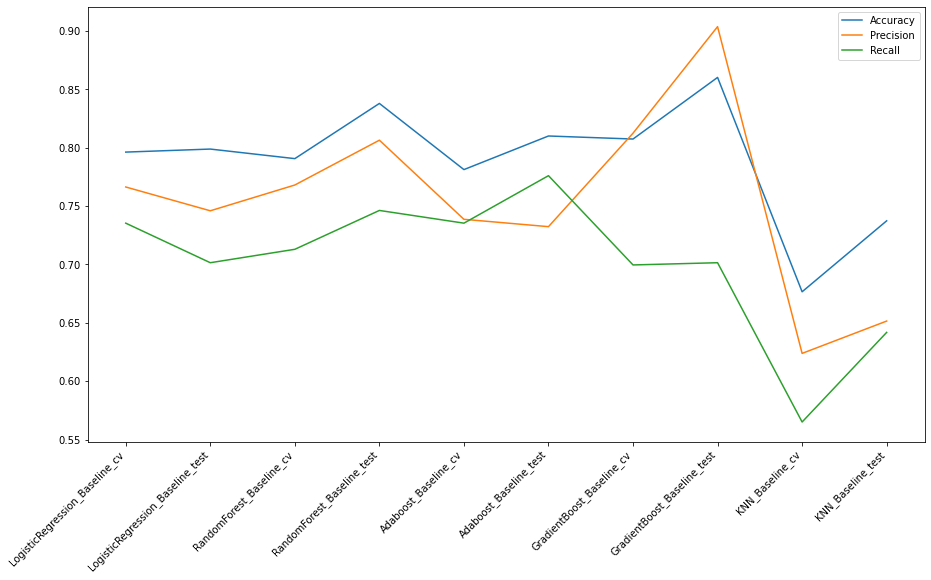

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
plt.plot(final["accuracy"], label="Accuracy")
plt.plot(final["precision"], label="Precision")
plt.plot(final["recall"], label="Recall")
plt.legend()
plt.xticks(rotation=45, ha='right'); #fig.autofmt_xdate(rotation=45)